In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from data_provider import data_provider
from alt_rbm import RBM
from pathlib import Path
from run_multiple_models import run_rbms

b'943 users\n1682 items\n100000 ratings\n'
  user_id movie_id  rating  unix_timestamp
0     195      241     3.0       881250949
1     185      301     3.0       891717742
2      21      376     1.0       878887116
3     243       50     2.0       880606923
4     165      345     1.0       886397596
              rating  unix_timestamp
count  100000.000000    1.000000e+05
mean        3.529860    8.835289e+08
std         1.125674    5.343856e+06
min         1.000000    8.747247e+08
25%         3.000000    8.794487e+08
50%         4.000000    8.828269e+08
75%         4.000000    8.882600e+08
max         5.000000    8.932866e+08


Text(0.5, 1.0, 'Histogram ocen')

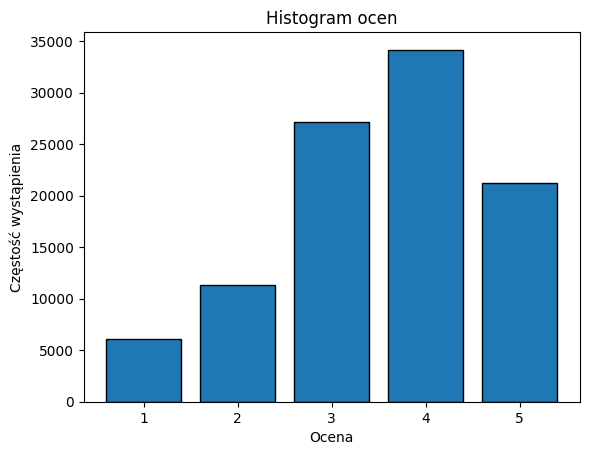

In [2]:
provider = data_provider()
ratings = provider.get_ratings()
print(ratings.head())
print(ratings.describe())
bin_edges = np.arange(0.5, 6.5, 1)
plt.hist(ratings['rating'], bins=bin_edges, align='mid', rwidth=0.8, edgecolor='black')
plt.xticks(np.arange(1, 6, 1))
plt.ylabel('Częstość wystąpienia')
plt.xlabel('Ocena')
plt.title('Histogram ocen')

In [3]:
ratings_sparse = ratings.pivot_table(index='user_id', columns='movie_id', values='rating', fill_value=0)
print(ratings_sparse.shape)
training_data_df, test_data_df = provider.split_dataframe(ratings_sparse, random_seed=42)
# Change data to 0 or 1 values
training_data_df = training_data_df.applymap(lambda x: 0 if x < 3 else 1)
test_data_df = test_data_df.applymap(lambda x: 0 if x < 3 else 1)
cross_validation_data = provider.cross_validation_split(training_data_df, holdout_fraction=0.2, random_seed=42)
training_data = training_data_df.to_numpy()
test_data = test_data_df.to_numpy()

print(training_data.shape)
print(training_data)
print(test_data.shape)

(943, 1682)
(849, 1682)
[[1 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(94, 1682)


In [23]:
rbm = RBM(training_data, 12, iterations=1000, random_seed=42)
rbm.set_debug(True)
filename = "rbm42.json"
directory = os.getcwd()
rbm_file_path = Path(os.path.join(directory, "rbm_models", filename))
if not rbm_file_path.is_file():
    iter_error = rbm.train(return_error=True)
    rbm.save_to_file(filename)
    # saving training results to file for plotting
    path = Path(os.path.join(directory, "training_results", filename))
    path.parent.mkdir(parents=True, exist_ok=True)
    data = {
        'iter_error': iter_error
    }
    with path.open('w') as file:
        json.dump(data, file)
else:
    rbm.load_from_file(filename)
    # loading training results for plotting
    path = Path(os.path.join(directory, "training_results", filename))
    if path.is_file():
        with path.open('r') as file:
          data = json.load(file)
          iter_error = np.array(data['iter_error'])

89.48047977659954


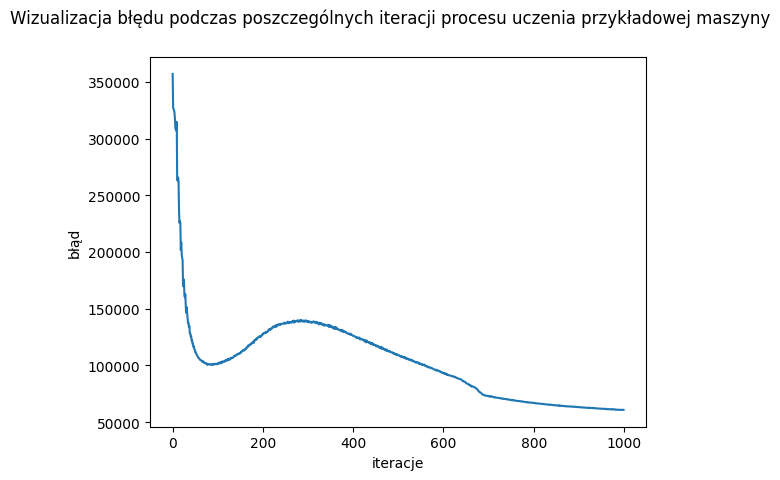

In [44]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(range(len(iter_error)), iter_error)
ax.set_xlabel('iteracje')
ax.set_ylabel('błąd')
fig.suptitle('Wizualizacja błędu podczas poszczególnych iteracji procesu uczenia przykładowej maszyny')
print(iter_error[-1]/training_data.shape[0])

In [16]:
_, train_error = rbm.get_recommendations_error(training_data)
_, test_error = rbm.get_recommendations_error(test_data)
print(train_error/training_data.shape[0])
print(test_error/test_data.shape[0])

71.53109242490325
77.54926569350155


Test różnych ilości iteracji uczenia

In [4]:
test_iterations = [200, 400, 600, 800]

In [5]:
# cross validation test to find optimal iterations
cross_validation_result_iter = []
for iterations in test_iterations:
    rbms = []
    for training_data, _ in cross_validation_data:
        rbm = RBM(training_data, 12, learning_rate=0.15, iterations=iterations, random_seed=42)
        rbms.append(rbm)
    test_results = run_rbms(rbms)
    train_errors = []
    validation_errors = []
    for index, result in enumerate(test_results):
        rbm, train_error = result
        training_data, validation_data = cross_validation_data[index]
        _, validation_error = rbm.get_recommendations_error(validation_data)
        train_errors.append(train_error[-1]/training_data.shape[0])
        validation_errors.append(validation_error/validation_data.shape[0])
    train_error_mean = np.array(train_errors).mean()
    validation_error_mean = np.array(validation_errors).mean()
    cross_validation_result_iter.append([iterations, train_error_mean, validation_error_mean])
print(cross_validation_result_iter)

[[200, 114.97051282902108, 115.30989131170399], [400, 78.8412522444282, 80.15910904408668], [600, 74.42811024530985, 76.4039302130563], [800, 71.86666714257396, 74.51194255755244]]


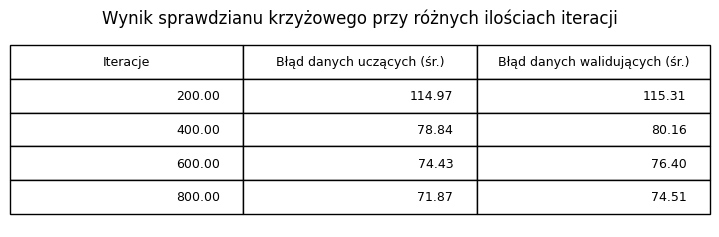

In [6]:
cross_validation_result_iter = [[round(j, 2) for j in i] for i in cross_validation_result_iter]
fig, ax = plt.subplots(figsize=(10,5))
table_data = [['{:.2f}'.format(j) for j in i] for i in cross_validation_result_iter]
table = plt.table(cellText=table_data, colLabels=['Iteracje', 'Błąd danych uczących (śr.)', 'Błąd danych walidujących (śr.)'], loc='center')
table.scale(1,4)
plt.title('Wynik sprawdzianu krzyżowego przy różnych ilościach iteracji')
plt.subplots_adjust(left=0.2, top=0.5)
plt.axis('off')
plt.show()

Test różnych współczynników uczenia

In [22]:
testing_learning_rates = [0.05, 0.1, 0.2, 0.4]

In [34]:
rbms = [RBM(training_data, 12, learning_rate=rate, iterations=500, random_seed=42) for rate in testing_learning_rates]
test_results = run_rbms(rbms)

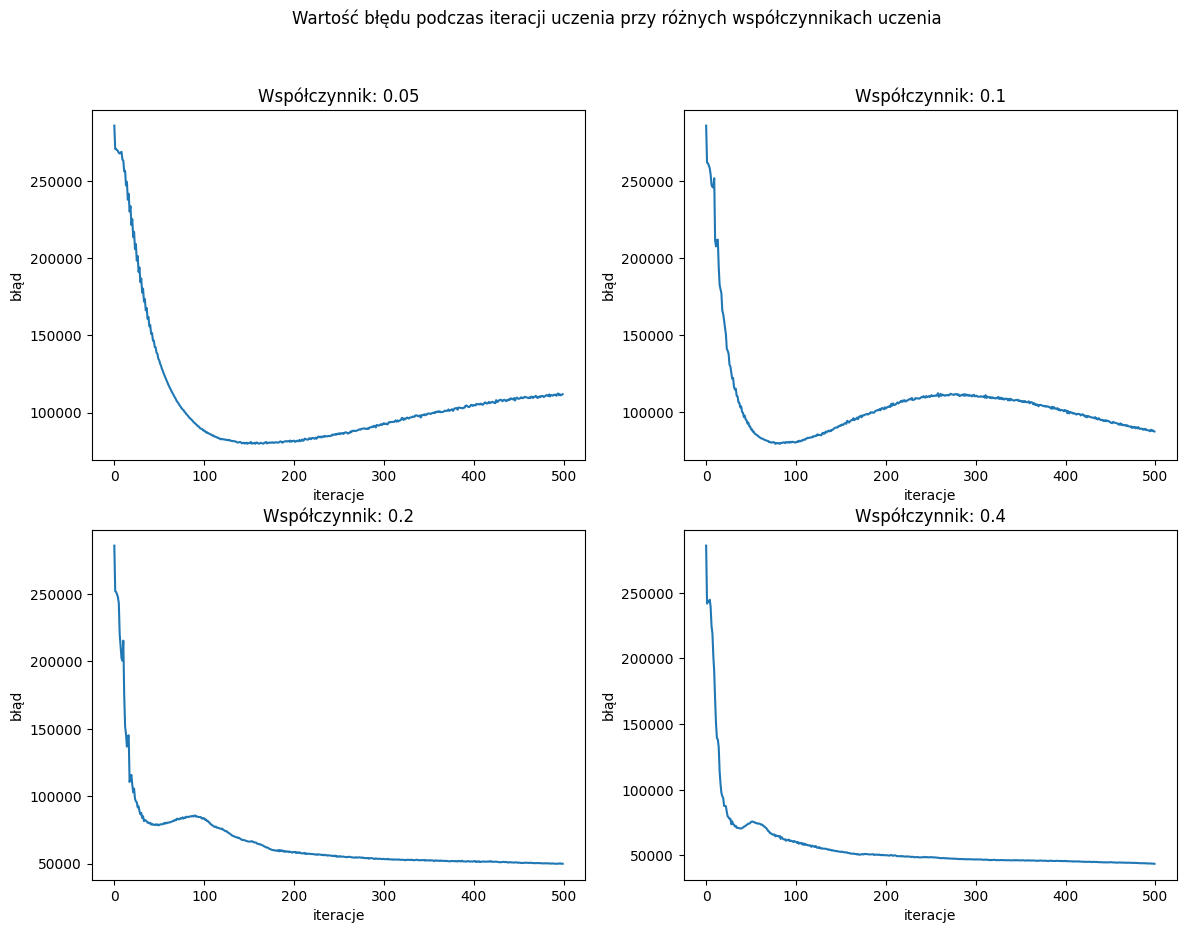

In [35]:
fig = plt.figure(figsize=(14,10))
fig.suptitle('Wartość błędu podczas iteracji uczenia przy różnych współczynnikach uczenia')
for index, result in enumerate(test_results):
    ax = fig.add_subplot(2,2,index+1)
    rbm, error = result
    ax.plot(range(len(error)), error)
    ax.set_title('Współczynnik: '+str(rbm.get_parameters()['learning_rate']))
    ax.set_xlabel('iteracje')
    ax.set_ylabel('błąd')
plt.show()

In [23]:
# cross validation test to find optimal learning rate
cross_validation_result_lr = []
for learning_rate in testing_learning_rates:
    rbms = []
    for training_data, _ in cross_validation_data:
        rbm = RBM(training_data, 12, learning_rate=learning_rate, iterations=500, random_seed=42)
        rbms.append(rbm)
    test_results = run_rbms(rbms)
    train_errors = []
    validation_errors = []
    for index, result in enumerate(test_results):
        rbm, train_error = result
        training_data, validation_data = cross_validation_data[index]
        _, validation_error = rbm.get_recommendations_error(validation_data)
        train_errors.append(train_error[-1]/training_data.shape[0])
        validation_errors.append(validation_error/validation_data.shape[0])
    train_error_mean = np.array(train_errors).mean()
    validation_error_mean = np.array(validation_errors).mean()
    cross_validation_result_lr.append([learning_rate, train_error_mean, validation_error_mean])
print(cross_validation_result_lr)

[[0.05, 163.32571711261667, 165.41248206871768], [0.1, 128.47182931665213, 129.38556317096345], [0.2, 73.65578055105998, 76.03145611040635], [0.4, 64.01003183300887, 67.9357448871347]]


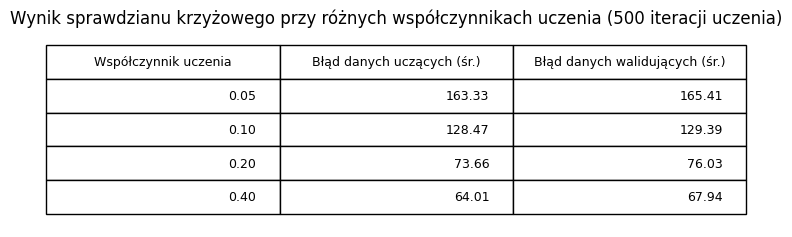

In [30]:
cross_validation_result_lr = [[round(j, 2) for j in i] for i in cross_validation_result_lr]
fig, ax = plt.subplots(figsize=(10,5))
table_data = [['{:.2f}'.format(j) for j in i] for i in cross_validation_result_lr]
table = plt.table(cellText=table_data, colLabels=['Współczynnik uczenia', 'Błąd danych uczących (śr.)', 'Błąd danych walidujących (śr.)'], loc='center')
table.scale(1,4)
plt.title('Wynik sprawdzianu krzyżowego przy różnych współczynnikach uczenia (500 iteracji uczenia)')
plt.subplots_adjust(left=0.2, top=0.5)
plt.axis('off')
plt.show()

Test różnych ilości ukrytych węzłów

In [5]:
testing_hidden_nodes_num = [6, 10, 16, 24]

In [4]:
rbms = [RBM(training_data, hidden_nodes, learning_rate=0.15, iterations=500, random_seed=42) for hidden_nodes in testing_hidden_nodes_num]
test_results = run_rbms(rbms)

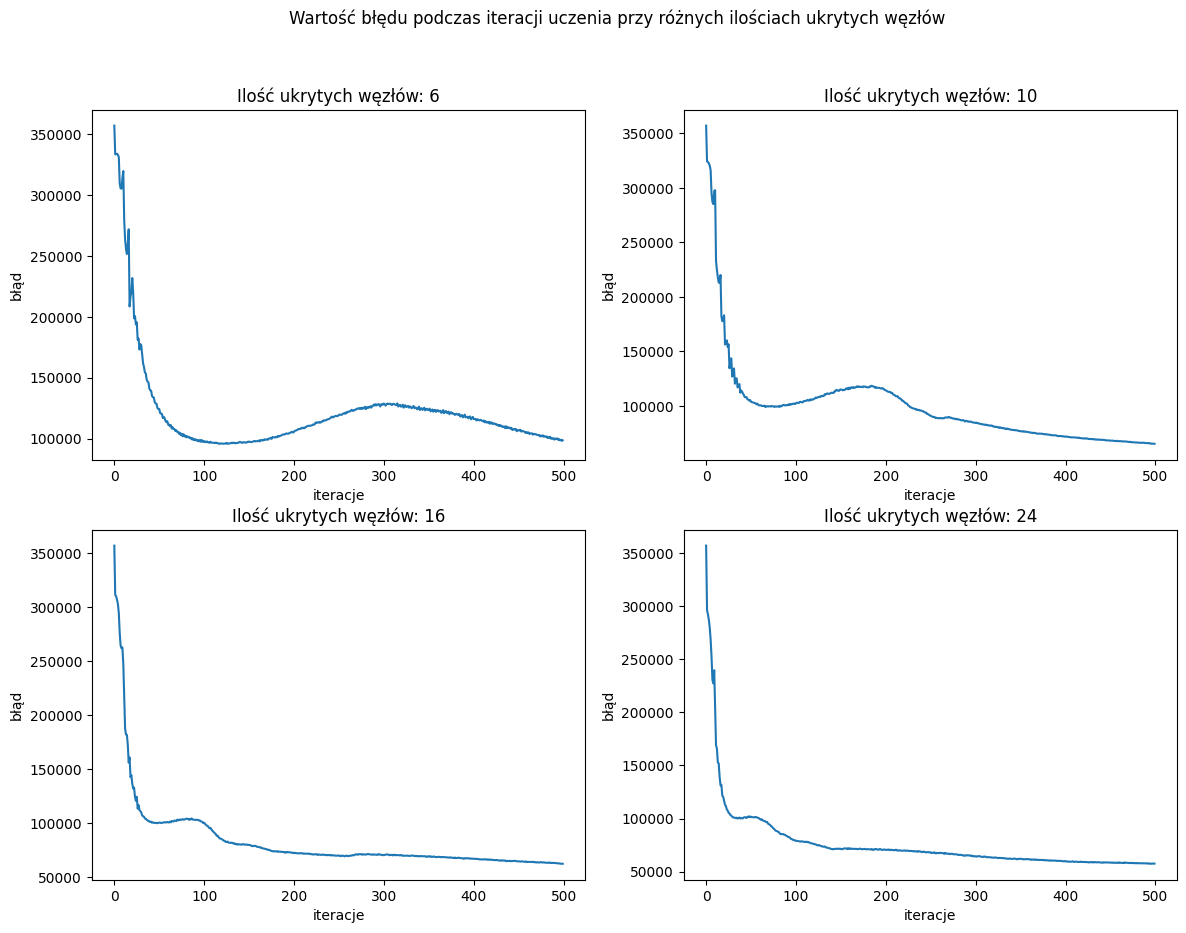

In [5]:
fig = plt.figure(figsize=(14,10))
fig.suptitle('Wartość błędu podczas iteracji uczenia przy różnych ilościach ukrytych węzłów')
for index, result in enumerate(test_results):
    ax = fig.add_subplot(2,2,index+1)
    rbm, error = result
    ax.plot(range(len(error)), error)
    ax.set_title('Ilość ukrytych węzłów: '+str(rbm.get_parameters()['hidden_nodes_num']))
    ax.set_xlabel('iteracje')
    ax.set_ylabel('błąd')
plt.show()

In [6]:
# cross validation to test various hidden nodes settings
cross_validation_result_hn = []
for hidden_nodes_num in testing_hidden_nodes_num:
    rbms = []
    for training_data, _ in cross_validation_data:
        rbm = RBM(training_data, learning_rate=0.15, hidden_nodes_num=hidden_nodes_num, iterations=500, random_seed=42)
        rbms.append(rbm)
    test_results = run_rbms(rbms)
    train_errors = []
    validation_errors = []
    for index, result in enumerate(test_results):
        rbm, train_error = result
        training_data, validation_data = cross_validation_data[index]
        _, validation_error = rbm.get_recommendations_error(validation_data)
        train_errors.append(train_error[-1]/training_data.shape[0])
        validation_errors.append(validation_error/validation_data.shape[0])
    train_error_mean = np.array(train_errors).mean()
    validation_error_mean = np.array(validation_errors).mean()
    cross_validation_result_hn.append([hidden_nodes_num, train_error_mean, validation_error_mean])
print(cross_validation_result_hn)

[[6, 116.20032558715627, 116.80647543069729], [10, 76.78458252954302, 77.7027597662539], [16, 73.92638260015022, 77.81610971046184], [24, 66.07702889731738, 69.45468663646554]]


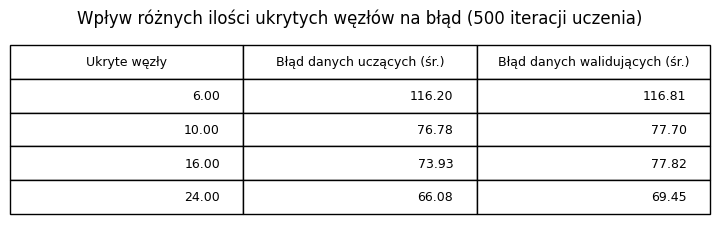

In [7]:
cross_validation_result_hn = [[round(j, 2) for j in i] for i in cross_validation_result_hn]
fig, ax = plt.subplots(figsize=(10,5))
table_data = [['{:.2f}'.format(j) for j in i] for i in cross_validation_result_hn]
table = plt.table(cellText=table_data, colLabels=['Ukryte węzły', 'Błąd danych uczących (śr.)', 'Błąd danych walidujących (śr.)'], loc='center')
table.scale(1,4)
plt.title('Wpływ różnych ilości ukrytych węzłów na błąd (500 iteracji uczenia)')
plt.subplots_adjust(left=0.2, top=0.5)
plt.axis('off')
plt.show()

Test generacji rekomendacji

In [13]:
rbm = RBM(training_data, learning_rate=0.15, hidden_nodes_num=10, iterations=500, random_seed=42)
rbm.train()

In [24]:
sample_user = test_data[0,:]
sample_user_recommendations = rbm.get_recommendations(np.array([sample_user]))
sample_user_recommendations

array([[1., 0., 1., ..., 0., 0., 0.]])

In [25]:
sample_user_ids = np.nonzero(sample_user)[0]
sample_user_recommendations_ids = np.nonzero(sample_user_recommendations[0])[0]
sample_user_recommendations_ids.size

241

In [16]:
movies = provider.get_movies()

print(movies.head())

  movie_id              title release_date  video_release_date  \
0        0   Toy Story (1995)  01-Jan-1995                 NaN   
1        1   GoldenEye (1995)  01-Jan-1995                 NaN   
2        2  Four Rooms (1995)  01-Jan-1995                 NaN   
3        3  Get Shorty (1995)  01-Jan-1995                 NaN   
4        4     Copycat (1995)  01-Jan-1995                 NaN   

                                            imdb_url  genre_unknown  Action  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...              0       0   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...              0       1   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...              0       0   
3  http://us.imdb.com/M/title-exact?Get%20Shorty%...              0       1   
4  http://us.imdb.com/M/title-exact?Copycat%20(1995)              0       0   

   Adventure  Animation  Children  ...  Film-Noir  Horror  Musical  Mystery  \
0          0          1         1  ...          0

In [8]:
def get_movies_data(movie_ids, with_rates = False):
    movie_ids = [int(id) for id in movie_ids]
    data = movies.iloc[movie_ids]
    if with_rates:
        rates = (data.iloc[:,6:-1].mean()*100).round(2)
        return data, rates
    else:
        return data

In [26]:
chosen_movies, chosen_rates = get_movies_data(sample_user_ids, with_rates=True)
recommended_movies, recommended_rates = get_movies_data(sample_user_recommendations_ids, with_rates=True)
categories = movies.columns[6:-1]

print(recommended_movies)
category_rates = list(zip(categories, recommended_rates, chosen_rates))
sorted_category_rates = sorted(category_rates, key=lambda x: x[1], reverse=True)

     movie_id                                title release_date  \
0           0                     Toy Story (1995)  01-Jan-1995   
2           2                    Four Rooms (1995)  01-Jan-1995   
3           3                    Get Shorty (1995)  01-Jan-1995   
14         14            Mr. Holland's Opus (1995)  29-Jan-1996   
22         22                   Taxi Driver (1976)  16-Feb-1996   
...       ...                                  ...          ...   
1638     1638  Bitter Sugar (Azucar Amargo) (1996)  22-Nov-1996   
1648     1648                  Big One, The (1997)  27-Mar-1998   
1649     1649              Butcher Boy, The (1998)  01-Jan-1998   
1660     1660                  New Age, The (1994)  01-Jan-1994   
1671     1671                          Kika (1993)  01-Jan-1993   

      video_release_date                                           imdb_url  \
0                    NaN  http://us.imdb.com/M/title-exact?Toy%20Story%2...   
2                    NaN  http://us.i

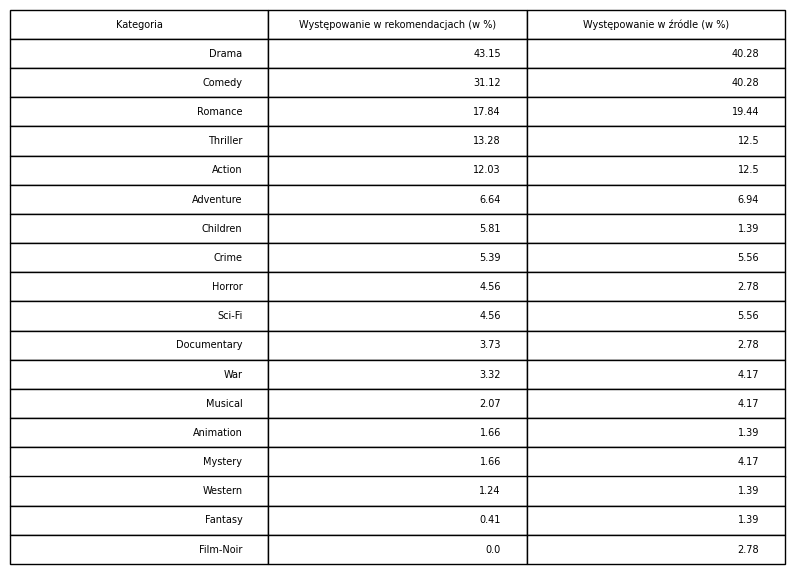

In [27]:
fig, ax = plt.subplots(figsize=(10, 5))
table = plt.table(cellText=sorted_category_rates, colLabels=['Kategoria', 'Występowanie w rekomendacjach (w %)', 'Występowanie w źródle (w %)'], loc='center')
table.scale(1, 1.75)
ax.axis('off')
plt.show()